# Hashing (Hashování, Rozptylování)

Při programováním často potřebujeme ukládat a číst různá data. Toto lze dělat různými způsoby, můžeme je uložit pomocí stromů, seznamů, či polí. Pochopitelně bychom chtěli zapisovat a číst co nejrychleji. Nabízí se tedy použít pole. přístupy i čtení z pole jsou přeci O(1). Jenže přímé indexování pole má problém, co když naše data nejsou kladná celá čísla? Nebo co když jsou větší než je rozsah pole? Jak bychom vložili číslo 145 do pole o velikosti 10?

Zde přichází na řadu hashování, hashovací funkce vezme prvek a přiřadí mu kladnou celoučíselnou hodnotu, kterou lze přímo indexovat pole (hashovací tabulku). Zajisté si pamatujete metodu hashCode z tříd v Javě. To je hashovací funkce pro vaši třídu.

S použitím hashů ovšem přichází i problém. Hashovací funkce nám může přiřadit stejný hash různým prvkům. Nastávají tedy kolize, které musíme řešit. Prvkům se stejným hashem říkáme synonyma.

Ideálně chceme, aby hashovací funkce:
- Byla rychlá
- Vedla k minimu kolízí
- Rovnoměrně využívala adresy (i blízké klíče na vzdálené adresy)
- Umisťovala prvky cca "náhodně"

Od hashovací funkce zároveň požadujeme, aby byla deterministická. Pro stejný objekt musí vždy vrátit stejnou hodnotu.

Nejzákladnější hashovací funkce je zbytek po dělení celým číslem (modulo, v Pythonu %), nejčastěji ji používáme tak, že bereme modulo velikostí tabulky. Tím zajistíme, že se do tabulky vejdeme.

In [1]:
def basic_hash(key, modulo):
    return key % modulo

### Úloha 1
Do nejprve prázdné tabulky s rozptylovací funkcí h(x)=x mod 6 byly vloženy následující prvky v uvedeném pořadí a celkem nastala jedna kolize.
- a) 6, 12, 24
- b) 24, 6, 12
- c) 1, 7, 6
- d) 5, 6, 7
- e) 2, 3, 4

In [2]:
from functools import partial

POSSIBLE_KEYS = {
    'a)': [6,12,24],
    'b)': [24,6,12],
    'c)': [1,7,6],
    'd)': [5,6,7],
    'e)': [2,3,4]
}

for option, keys in POSSIBLE_KEYS.items():
    print(f'{option}: {list(map(partial(basic_hash, modulo=6), keys))}')


a): [0, 0, 0]
b): [0, 0, 0]
c): [1, 1, 0]
d): [5, 0, 1]
e): [2, 3, 4]


Hashování je velmi důležité pro implementaci slovníků (dictionary v Pythonu, HashMap v Javě). Ve slovníku ukládáme dvojice (klíč, hodnota) a používáme hash klíče. V tomto notebooku si postačíme s Hashovací tabulkou pouze s klíči bez uložených hodnot, k vysvětlení principů je to postačující.

In [3]:
import copy

class HashTable:
    def __init__(self, size, hash_function, cell_size=5, empty_cell = '_'):
        self.EMPTY_CELL = empty_cell
        self.size = size
        self.key_table = [copy.deepcopy(self.EMPTY_CELL) for _ in range(size)]
        self.cell_size = cell_size
        self.hash = hash_function
        self.occupancy = 0

    def insert(self, key):
        idx = self.hash(key)
        collisions = 0

        if self.key_table[idx] == self.EMPTY_CELL:
            self.key_table[idx] = key
            self.occupancy += 1
        else:
            collisions += 1

        return collisions

    def insert_keys(self, keys, verbose=False):
        total_collisions = 0
        for key in keys:
            collisions = self.insert(key)
            total_collisions += collisions
            if verbose:
                print(f'Encountered {collisions} collisions while inserting {key}.')
                print(self)

        return total_collisions

    def get(self, key):
        idx = self.hash(key)
        collisions = 0

        if self.key_table[idx] != key:
            collisions += 1

        return collisions

    def get_keys(self, keys, verbose=False):
        total_collisions = 0
        for key in keys:
            collisions = self.get(key)
            total_collisions += collisions
            if verbose:
                print(f'Encountered {collisions} collisions while getting {key}.')

        return total_collisions

    def __str__(self):
        row_separator = '-' * ((self.cell_size + 1) * self.size + 1) + '\n'
        output = row_separator

        for i in range(self.size):
            output += f'|{i:^{self.cell_size}}'
        output += '|\n'

        output += row_separator

        for i in range(self.size):
            output += f'|{self.key_table[i]:^{self.cell_size}}'
        output += '|\n'

        output += row_separator

        return output

Kolize při hashování lze řešit různými způsoby:
- Chaining (Zřetězené rozptylování)
- Open-address hashing (Otevřené rozptylování)
- Coalesced hashing (Srůstající hashování)

## Chaining (Zřetězené rozptylování)



Na každé adrese tvoříme spojovaný seznam klíčů se stejnou adresou (hashem).
Abychom zajistili rychlé vkládání, tak v zřetězeném hashování vkládáme prvky na začátek spojovaného seznamu.

### Úloha 2

Pro danou rozptylovací funkci h(k)=k mod 5 zvolte velikost tabulky a nakreslete stav po vložení prvků následující posloupnosti při vnějším zřetězení prvků.

20, 9, 0, 17, 22, 15, 23, 18, 8, 7

### Úloha 3
Doplňte implementaci zřetězeného hashování.

In [4]:
class ChainingHashTable(HashTable):
    def __init__(self, size, hash_function, cell_size=5):
        super().__init__(size, hash_function, cell_size, empty_cell=[])

    def insert(self, key):
        idx = self.hash(key)
        # Následující řádek bude smazán a zadání na cviko bude: TODO: Add code for adding the key to the hash table
        self.key_table[idx].insert(0, key)
        self.occupancy += 1
        return 0

    def get(self, key):
        collisions = 0
        idx = self.hash(key)

        for k in self.key_table[idx]:
            if k != key:
                collisions += 1
            else:
                # Hurray, we found an entry with the key. If we had values, here we would return the value associated with the key.
                break

        return collisions

    def __str__(self):
        row_separator = '-' * ((self.cell_size + 1) * self.size + 1) + '\n'
        output = row_separator

        for i in range(self.size):
            output += f'|{i:^{self.cell_size}}'
        output += '|\n'

        output += row_separator

        max_chain_size = max(len(chain) for chain in self.key_table)
        for d in range(max_chain_size):
            for i in range(self.size):
                if len(self.key_table[i]) > d:
                    output += f'|{self.key_table[i][d]:^{self.cell_size}}'
                else:
                    output += f'|{"":^{self.cell_size}}'
            output += '|\n'

        output += row_separator

        return output

Správnost naší implementace můžeme ověřit srovnáním s výsledkem 2. úlohy.

In [5]:
from functools import partial

TABLE_SIZE = 5
KEYS=20,9,0,17,22,15,23,18,8,7
HASH_TABLE = ChainingHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)


-------------------------------
|  0  |  1  |  2  |  3  |  4  |
-------------------------------
| 15  |     |  7  |  8  |  9  |
|  0  |     | 22  | 18  |     |
| 20  |     | 17  | 23  |     |
-------------------------------



## Open-address hashing

Vše vkládáme do stejné tabulky a při kolizi zkoušíme pozici o i⋅k polí dál, kde i je počet kolizí daného klíče a k se určí pomocí:
- Linear probing - k je konstanta, tedy zkoušíme vždy pozici o k dále (modulo velikost tabulky);
- Double hashing - k=h2(x), čili máme další hashovací funkci h2, která nám určí (povětšinou) rozdílná k pro rozdílná x.

### Úloha 4
Vložte následudící posloupnost prvků do hashovací tabulky o velikosti m=11, pomocí otevřeného hashování.

5, 6, 1, 10, 13, 18, 14, 30, 0, 8, 16

Vkládejte najednou do 3 tabulek, ve dvou uvažujte linear probing s inkrementem 1 a 3, v poslední provádějte double hashing. Hashovací funkce:

h1(x)= x mod 8, h2(x)=(x mod 7) + 1

### Úloha 5

Doplňte implementaci otevřeného hashování.

In [6]:
class OpenAddressHashTable(HashTable):
    def __init__(self, size, hash_function, probe_function, cell_size=5):
        super().__init__(size, hash_function, cell_size)
        self.probe_function = probe_function

    def insert(self, key):
        collisions = 0
        idx = self.hash(key)
        probe_offset = self.probe_function(key) # k
        first_idx = idx

        # Následující while cyklus bude smazán a úloha na cvičení bude doplnit posun indexů. TODO: Add code moving the index by k in case of collision, self.EMPTY_CELL indicates an empty cell, self.size is the size of the table
        while (self.key_table[idx] != self.EMPTY_CELL
               and (collisions == 0 or first_idx != idx)): # Prevents looping when table is too full
            collisions += 1
            idx = (idx + probe_offset) % self.size

        if self.key_table[idx] == self.EMPTY_CELL:
            self.key_table[idx] = key
            self.occupancy += 1

        return collisions

    def get(self, key):
        collisions = 0
        idx = self.hash(key)
        probe_offset = self.probe_function(key)
        first_idx = idx
        while (self.key_table[idx] != key
               and self.key_table[idx] != self.EMPTY_CELL
               and (collisions == 0 or first_idx != idx)): # Prevents looping when table is too full
            collisions += 1
            idx = (idx + probe_offset) % self.size

        # if self.key_table[idx] != self.EMPTY_CELL:
            # Hurray, we found an entry with the key. If we had values, here we would return the value associated with the key.

        return collisions


Správnost naší implementace si můžeme ověřit srovnáním s výsledky úlohy 4.

### Linear probing s inkrementem 1

In [7]:
TABLE_SIZE = 11
KEYS=[5,6,1,10,13,18,14,30,0,8,16]
LINEAR_INCREMENT = 1

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=lambda key: LINEAR_INCREMENT)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')


-------------------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  |
-------------------------------------------------------------------
|  0  |  1  | 10  | 18  |  8  |  5  |  6  | 13  | 14  | 30  | 16  |
-------------------------------------------------------------------

In total we encountered 22 insert collisions.


### Linear probing s inkrementem 3

In [8]:
TABLE_SIZE = 11
KEYS=[5,6,1,10,13,18,14,30,0,8,16]
LINEAR_INCREMENT = 3

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=lambda key: LINEAR_INCREMENT)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  |
-------------------------------------------------------------------
| 18  |  1  | 10  |  0  | 30  |  5  |  6  |  8  | 13  | 14  | 16  |
-------------------------------------------------------------------

In total we encountered 22 insert collisions.


### Linear probing s double hashing

In [9]:
TABLE_SIZE = 11
KEYS=[5,6,1,10,13,18,14,30,0,8,16]

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=lambda key: key % 7 + 1)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  |
-------------------------------------------------------------------
|  0  |  1  | 10  | 16  | 30  |  5  |  6  | 18  | 13  | 14  |  8  |
-------------------------------------------------------------------

In total we encountered 15 insert collisions.


## Coalesced hashing (Srůstající hashování)
Hybrid mezi zřetězeným a otevřeným hashováním, vše vkládáme do stejné tabulky a v případě kolizí vkládáme odzadu. Každý prvek má navíc ještě ukazatel, který ukazuje na pozici dalšího prvku v případě kolize. Máme různé metody tvorby ukazatelů v případě kolize. Jednotlivé metody můžeme dále dělit podle toho, zda je na konci pole tzv. sklep, tedy část pole kterou nelze adresovat pomocí hashovací funkce (lze do ní vkládat jen při kolizích).

- Bez sklepa
    - LISCH - Late Insert Standard Coalesced Hashing - na pozici právě přidaného prvku ukazuje poslední prvek se kterým byla kolize (poslední v řetězu)

    - EISCH - Early Insert Standard Coalesced Hashing - na pozici právě přidaného prvku ukazuje první prvek se kterým došlo ke kolizi, přidaný prvek ukazuje na ten co býval druhý v řetězu (pokud existuje).

- Se sklepem
    - LICH - Late Insert Coalesced Hashing - jako LISCH, ale nejprve vkládáme kolize do sklepa (protože je na konci)

    - EICH - Early Insert Coalesced Hashing - jako EISCH, ale nejprve vkládáme kolize do sklepa (protože je na konci)

    - VICH - Variable Insert Coalesced Hashing - dokud vkládáme kolize do sklepa, vkládáme je podle LICH. Jakmile je sklep plný, vkládáme těsně za poslední prvek v řetězu který je ve sklepě. Když žádný z řetězu ve sklepě není, vkládáme podle EICH.

### Úloha 6
Uvažujte hash funkci h(x)=x mod 9. Vložte do hashovací tabulky čísla z posloupnosti:

9, 11, 18, 27, 29, 36, 43, 45, 50

Jak bude tabulka vypadat pro EISCH a jak pro LISCH?

### Úloha 7
Doplňte implementaci metody get pro srůstající hashování.

In [10]:
class CoalescedHashTable(HashTable):
    def __init__(self, size, hash_function, cell_size=5):
        super().__init__(size, hash_function, cell_size=cell_size)
        self.next_ptr_table = [self.EMPTY_CELL] * size

    def insert(self, key):
        raise NotImplementedError('This method must be implemented by a subclass!')

    def get(self, key):
        idx = self.hash(key)
        collisions = 0

        # Tenhle while budou studenti doplňovat. TODO: Add code for finding the key in the hash table
        while (self.key_table[idx] != key) and (self.next_ptr_table[idx] != self.EMPTY_CELL):
            idx = self.next_ptr_table[idx]
            collisions += 1

        return collisions

    def __str__(self):
        row_separator = '-' * ((self.cell_size + 1) * self.size + 1) + '\n'
        output = super().__str__()

        for i in range(self.size):
            output += f'|{self.next_ptr_table[i]:^{self.cell_size}}'
        output += '|\n'

        output += row_separator

        return output

### Úloha 8
Doplňte implementaci metody insert pro LISCH hashovací tabulku.

In [11]:
class LISCHHashTable(CoalescedHashTable):
    def __init__(self, size, hash_function, cell_size=5):
        super().__init__(size, hash_function, cell_size=cell_size)
        self.next_free = size - 1

    def insert(self, key):
        idx = self.hash(key)
        collisions = 0

        if self.key_table[idx] == self.EMPTY_CELL:
            self.key_table[idx] = key
        else:
            collisions += 1
            while self.key_table[self.next_free] != self.EMPTY_CELL:
                self.next_free -= 1

            self.key_table[self.next_free] = key

            next_ptr = idx

            # Tenhle while a řádek pod ním budou studenti doplňovat. TODO: Add code for setting the pointer to the next entry in the collision chain
            while self.next_ptr_table[next_ptr] != self.EMPTY_CELL:
                next_ptr = self.next_ptr_table[next_ptr]
                collisions += 1
            self.next_ptr_table[next_ptr] = self.next_free

        return collisions

Správnost naší implementace můžeme ověřit srovnáním s výsledky úlohy 6.

In [12]:
TABLE_SIZE = 9
KEYS = [9, 11, 18, 27, 29, 36, 43, 45, 50]

HASH_TABLE = LISCHHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |
-------------------------------------------------------
|  9  | 50  | 11  | 45  | 43  | 36  | 29  | 27  | 18  |
-------------------------------------------------------
|  8  |  _  |  6  |  1  |  3  |  4  |  _  |  5  |  7  |
-------------------------------------------------------

In total we encountered 17 insert collisions.


### Úloha 9
Doplňte implementaci metody insert pro EISCH hashovací tabulku.

In [13]:
class EISCHHashTable(CoalescedHashTable):
    def __init__(self, size, hash_function, cell_size=5):
        super().__init__(size, hash_function, cell_size=cell_size)
        self.next_free = size - 1

    def insert(self, key):
        idx = self.hash(key)
        collisions = 0

        if self.key_table[idx] == self.EMPTY_CELL:
            self.key_table[idx] = key
        else:
            collisions += 1
            while self.key_table[self.next_free] != self.EMPTY_CELL:
                self.next_free -= 1

            self.key_table[self.next_free] = key

            # Tyhle dva řádky budou studenti doplňovat. TODO: Add code for setting the pointer to the next entry in the collision chain
            self.next_ptr_table[self.next_free] = self.next_ptr_table[idx]
            self.next_ptr_table[idx] = self.next_free

        return collisions

Správnost naší implementace můžeme ověřit srovnáním s výsledky úlohy 6.

In [14]:
TABLE_SIZE = 9
KEYS = [9, 11, 18, 27, 29, 36, 43, 45, 50]

HASH_TABLE = EISCHHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |
-------------------------------------------------------
|  9  | 50  | 11  | 45  | 43  | 36  | 29  | 27  | 18  |
-------------------------------------------------------
|  3  |  7  |  6  |  5  |  8  |  1  |  _  |  4  |  _  |
-------------------------------------------------------

In total we encountered 7 insert collisions.


### Úloha 10
Uvažujte hash funkci h(x)=x mod 7 a sklep o velikosti 2. Vložte do hashovací tabulky čísla z (stejné) posloupnosti:

9, 11, 18, 27, 29, 36, 43, 45, 50

Jak bude tabulka vypadat pro EICH, LICH a jak pro VICH?

### Úloha 11
Co musíme změnit na implementaci LISCH hashovací tabulky, abychom dostali LICH hashovací tabulku?

In [15]:
class LICHHashTable(LISCHHashTable):
    def __init__(self, table_size, cellar_size, hash_function, cell_size=5):
        super().__init__(table_size+cellar_size, hash_function, cell_size=cell_size)

Správnost naší implementace můžeme ověřit srovnáním s výsledky úlohy 9.

In [16]:
TABLE_SIZE = 7
CELLAR_SIZE = 2
KEYS = [9, 11, 18, 27, 29, 36, 43, 45, 50]

HASH_TABLE = LICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |
-------------------------------------------------------
| 50  | 29  |  9  | 45  | 11  | 43  | 27  | 36  | 18  |
-------------------------------------------------------
|  _  |  7  |  _  |  _  |  8  |  0  |  _  |  5  |  _  |
-------------------------------------------------------

In total we encountered 7 insert collisions.


### Úloha 12
Co musíme změnit na implementaci EISCH hashovací tabulky, abychom dostali EICH hashovací tabulku?

In [17]:
class EICHHashTable(EISCHHashTable):
    def __init__(self, table_size, cellar_size, hash_function, cell_size=5):
        super().__init__(table_size + cellar_size, hash_function, cell_size=cell_size)


Správnost naší implementace můžeme ověřit srovnáním s výsledky úlohy 9.

In [18]:
TABLE_SIZE = 7
CELLAR_SIZE = 2
KEYS = [9, 11, 18, 27, 29, 36, 43, 45, 50]

HASH_TABLE = EICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |
-------------------------------------------------------
| 50  | 29  |  9  | 45  | 11  | 43  | 27  | 36  | 18  |
-------------------------------------------------------
|  5  |  0  |  _  |  _  |  8  |  7  |  _  |  _  |  _  |
-------------------------------------------------------

In total we encountered 4 insert collisions.


### Úloha 13
Projděte implementaci metody insert pro VICH hashovací tabulku.

In [19]:
class VICHHashTable(EICHHashTable):
    def __init__(self, table_size, cellar_size, hash_function, cell_size=5):
        super().__init__(table_size, cellar_size, hash_function, cell_size=cell_size)
        self.table_size = table_size
        self.cellar_size = cellar_size

    def insert(self, key):
        idx = self.hash(key)
        collisions = 0

        if self.key_table[idx] == self.EMPTY_CELL:
            self.key_table[idx] = key
        else:
            collisions += 1
            while self.key_table[self.next_free] != self.EMPTY_CELL:
                self.next_free -= 1

            self.key_table[self.next_free] = key

            next_ptr = idx
            while self.next_ptr_table[next_ptr] != self.EMPTY_CELL and self.next_ptr_table[next_ptr] >= self.table_size:
                collisions += 1
                next_ptr = self.next_ptr_table[next_ptr]

            if self.next_free < self.table_size:
                self.next_ptr_table[self.next_free] = self.next_ptr_table[next_ptr]
            self.next_ptr_table[next_ptr] = self.next_free

        return collisions

Správnost naší implementace můžeme ověřit srovnáním s výsledky úlohy 9.

In [20]:
TABLE_SIZE = 7
CELLAR_SIZE = 2
KEYS = [9, 11, 18, 27, 29, 36, 43, 45, 50]

HASH_TABLE = VICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

-------------------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |
-------------------------------------------------------
| 50  | 29  |  9  | 45  | 11  | 43  | 27  | 36  | 18  |
-------------------------------------------------------
|  5  |  7  |  _  |  _  |  8  |  _  |  _  |  0  |  _  |
-------------------------------------------------------

In total we encountered 6 insert collisions.


## Benchmarky srůstajícího hashování

In [21]:
import numpy as np

def generate_insert_data(key_range, num_keys):
    assert num_keys <= key_range
    return np.random.choice(a=key_range, size=num_keys, replace=False)

def generate_successful_read_data(keys, num_data):
    return np.random.choice(a=keys, size=num_data, replace=True)

def prepare_data(key_range, num_keys, num_data):
    keys = generate_insert_data(key_range, num_keys)
    read_data = generate_successful_read_data(keys, num_data)
    return keys, read_data

class Benchmark:
    def __init__(self, key_range, num_keys, num_read_data, address_factor, repetitions=5):
        self.key_range = key_range
        self.num_keys = num_keys
        self.num_read_data = num_read_data
        self.address_factor = address_factor
        self.repetitions = repetitions

    def run(self):
        insert_collision_results = {'LISCH':{}, 'EISCH':{},'LICH': {}, 'EICH': {}, 'VICH': {}}
        read_collision_results = {'LISCH':{}, 'EISCH':{},'LICH': {}, 'EICH': {}, 'VICH': {}}

        for _ in range(self.repetitions):
            keys, read_data = prepare_data(self.key_range, self.num_keys, self.num_read_data)

            for load_factor in np.linspace(0.5, 1, 51):
                total_size = int(self.num_keys/load_factor)
                table_size = int(total_size * self.address_factor)
                cellar_size = total_size - table_size

                tables = {'LISCH': LISCHHashTable(total_size, partial(basic_hash, modulo=total_size)),
                          'EISCH': EISCHHashTable(total_size, partial(basic_hash, modulo=total_size)),
                          'LICH': LICHHashTable(table_size, cellar_size, partial(basic_hash, modulo=table_size)),
                          'EICH': EICHHashTable(table_size, cellar_size, partial(basic_hash, modulo=table_size)),
                          'VICH': VICHHashTable(table_size, cellar_size, partial(basic_hash, modulo=table_size))}

                for label, table in tables.items():
                    collisions = table.insert_keys(keys, verbose=False)
                    insert_collision_results[label].setdefault(load_factor, []).append(collisions/len(keys))

                    collisions = table.get_keys(read_data, verbose=False)
                    read_collision_results[label].setdefault(load_factor, []).append(collisions/len(read_data))

        return {'insert_collision_results': insert_collision_results, 'read_collision_results': read_collision_results}


In [22]:
from matplotlib import pyplot as plt
plt.style.use('bmh')


def get_average_probes(collisions):
    return {label: {load_factor: 1 + np.average(colls) for load_factor, colls in collisions[label].items() } for label in collisions.keys()}


def plot_probes(probes, title):
    plt.figure(figsize=(10,10))
    for label in probes.keys():
        plt.plot(probes[label].keys(), probes[label].values(), label=label)

    plt.title(title)
    plt.xlabel('Load Factor')
    plt.ylabel('Average number of probes')
    plt.legend()
    plt.show()


### Úloha 14
Spusťne následující kód a srovnejte, která z metod srůstajícího hashování vyžaduje nejméně nahlédnutí do tabulky.

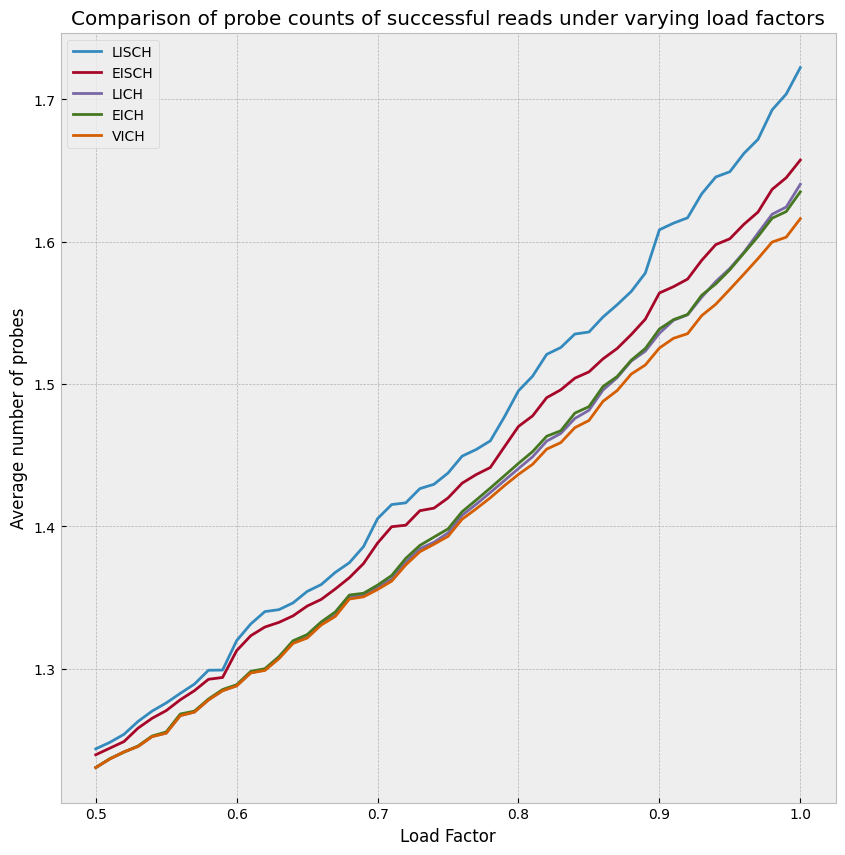

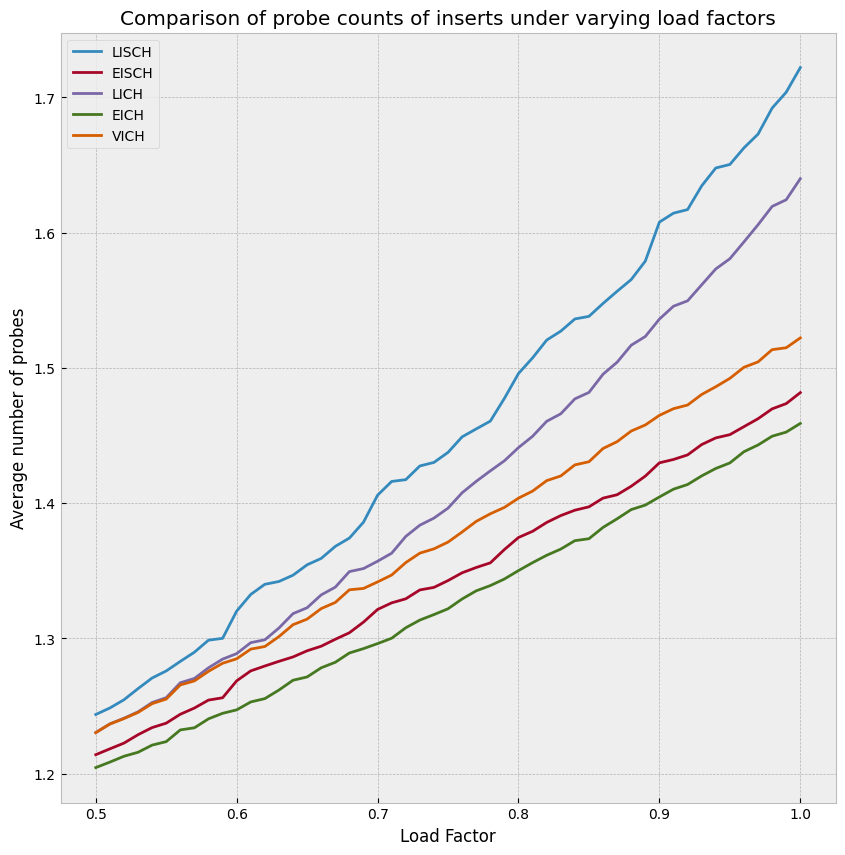

In [23]:
KEY_RANGE = int(1e4)
NUM_KEYS = int(1e3)
NUM_READ_DATA = int(1e4)

BENCHMARK = Benchmark(key_range=KEY_RANGE, num_keys=NUM_KEYS, num_read_data=NUM_READ_DATA, address_factor=0.9, repetitions=100)
RESULTS = BENCHMARK.run()

plot_probes(get_average_probes(RESULTS['read_collision_results']), title='Comparison of probe counts of successful reads under varying load factors')
plot_probes(get_average_probes(RESULTS['insert_collision_results']), 'Comparison of probe counts of inserts under varying load factors')

## HashTable objektů

Naše hashovací tabulky zvládnou více než pouhá čísla! Stejně jako v Javě i v Pythonu mají třídy metody, které vytvoří jejich hash. Pythoní ekvivalent metod hashCode a equals je __hash__ a __eq__.

### Úloha 15
Doplňte implementaci metody __hash__ třídy node.

In [24]:
class Node:
    def __init__(self, left_child, right_child, value):
        self.left_child = left_child
        self.right_child = right_child
        self.value = value

    def __hash__(self):
        # Nasledující řádek bude smazán a bude pro doplnění. TODO: Write the hash method for the Node class. Hint: use the Python hash function, which calls the __hash__ method of its input.
        return hash((self.left_child, self.right_child, self.value))

    def __eq__(self, other):
        return isinstance(other, self.__class__) and (self.left_child, self.right_child, self.value) == (other.left_child, other.right_child, other.value)

    def __str__(self):
        return f'{self.value}'

    def __format__(self, format_spec):
        return f'{self.value:{format_spec}}'

Ještě musíme upravit funkci basic_hash, aby využívala hash klíče místo klíče samotného.

In [25]:
def basic_hash(key, modulo):
    return hash(key) % modulo

A nyní ověříme funkčnost

In [26]:
from functools import partial

TABLE_SIZE = 7
KEYS=[Node(None, None, i) for i in range(17)]
for i in range(1, len(KEYS)):
    KEYS[i].parent = KEYS[i-1]
    KEYS[i-1].left_child = KEYS[i]

HASH_TABLE = ChainingHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)

-------------------------------------------
|  0  |  1  |  2  |  3  |  4  |  5  |  6  |
-------------------------------------------
| 12  |  6  |  3  | 16  | 14  |  9  |  7  |
| 10  |     |  0  | 15  | 13  |  4  |  5  |
|  2  |     |     |  8  | 11  |     |     |
|     |     |     |     |  1  |     |     |
-------------------------------------------



## Úlohy na procvičení:

### Úloha 16
Pro danou rozptylovací funkci h(k)=k mod 9 zvolte velikost tabulky a nakreslete stav po vložení prvků následující posloupnosti při vnějším zřetězení prvků.

12, 19, 24, 17, 4, 21, 5, 16, 11, 2

Výsledky zkontrolujte pomocí implementace zřetězeného hashování.

In [27]:
TABLE_SIZE = None #TODO
KEYS=12,19,24,17,4,21,5,16,11,2

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = ChainingHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)

Exception: Remove this line when you want to check your results.

### Úloha 17

Do rozptylovací tabulky velikosti 10 s otevřeným rozptylováním a s rozptylovací funkcí h(k)=k mod 7 vložte následujících 6 klíčů.

Použijte strategii Linear Probing s inkrementem 1.

12, 23, 15, 29, 22, 14

Výsledky zkontrolujte pomocí implementace otevřeného hashování.

In [ ]:
TABLE_SIZE = 10
KEYS=12,23,15,29,22,14
LINEAR_INCREMENT = 1

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=lambda key: LINEAR_INCREMENT)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

### Úloha 18

Do rozptylovací tabulky velikosti 11 s otevřeným rozptylováním a s rozptylovací funkcí h(k)=k mod 8 vložte následujících 6 klíčů.

Použijte strategii Linear Probing s inkrementem 3.

10, 16, 15, 31, 23, 14

Výsledky zkontrolujte pomocí implementace otevřeného hashování.

In [ ]:
TABLE_SIZE = 11
KEYS=10,16,15,31,23,14
LINEAR_INCREMENT = 3

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=lambda key: LINEAR_INCREMENT)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

### Úloha 19

 Do do prázdné tabulky velikosti N, vkládejte klíče:
27,23,2,28,17,7,14,30,12,21,11,1 Určete počet kolizí v uvedených variantách:

1. N=13, Linear Probing s inkrementem 1.
2. N=17, Linear Probing s inkrementem 1.
3. N=17, Linear Probing s inkrementem 5.
4. N=13, Double Hashing, h(k)=1+k mod 3.
5. N=13, Double Hashing, h(k)=1+k mod 5.
6. N=17, Double Hashing, h(k)=1+k mod 5.

Výsledky zkontrolujte pomocí implementace otevřeného hashování.

In [ ]:
TABLE_SIZE = 13 #TODO
KEYS=27,23,2,28,17,7,14,30,12,21,11,1

LINEAR_INCREMENT = 1

linear_probe = lambda key: LINEAR_INCREMENT
double_hashing_probe = lambda key: 1 + key % 3 # TODO

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = OpenAddressHashTable(TABLE_SIZE, partial(basic_hash, modulo=8), probe_function=linear_probe)

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

### Úloha 20

Uvažujte hash funkci h(x)=x mod 10. Vložte do hashovacích tabulek čísla z posloupnosti:
10, 12, 20, 23, 32, 39, 40

Jak bude tabulka vypadat pro EISCH a jak pro LISCH?

Výsledky zkontrolujte pomocí implementace srůstajícího hashování.

EISCH

In [ ]:
TABLE_SIZE = 10
KEYS = [10,12,20,23,32,39,40]

HASH_TABLE = EISCHHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

raise Exception('Remove this line when you want to check your results.')

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

LISCH

In [ ]:
TABLE_SIZE = 10
KEYS = [10,12,20,23,32,39,40]

HASH_TABLE = LISCHHashTable(TABLE_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

raise Exception('Remove this line when you want to check your results.')

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

### Úloha 21

Uvažujte hash funkci h(x)=x mod 8 a sklep o velikosti 2. Vložte do hashovacích tabulek čísla z (té samé) posloupnosti:
10, 12, 20, 23, 32, 39, 40

Jak bude tabulka vypadat pro EICH, LICH a jak pro VICH?

Výsledky zkontrolujte pomocí implementace srůstajícího hashování.

EICH

In [ ]:
TABLE_SIZE = 8
CELLAR_SIZE = 2
KEYS = [10,12,20,23,32,39,40]

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = EICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

LICH

In [ ]:
TABLE_SIZE = 8
CELLAR_SIZE = 2
KEYS = [10,12,20,23,32,39,40]

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = LICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

VICH

In [ ]:
TABLE_SIZE = 8
CELLAR_SIZE = 2
KEYS = [10,12,20,23,32,39,40]

raise Exception('Remove this line when you want to check your results.')

HASH_TABLE = VICHHashTable(TABLE_SIZE, CELLAR_SIZE, partial(basic_hash, modulo=TABLE_SIZE))

COLLISIONS = HASH_TABLE.insert_keys(KEYS, verbose=False)
print(HASH_TABLE)
print(f'In total we encountered {COLLISIONS} insert collisions.')

### Úloha 22

Předpokládejme, že v tabulkách získaných v příkladech 1 a 2, (případně 3 a 4) vyhledáváme pouze klíče v nich uložené a každý klíč stejně často. Která z těchto tabulek je nejvýhodnější?

Odpověď můžete ověřit pomocí metody get_keys(<vložené klíče>) po vložení klíčů do tabulky.